# Analysis of model results
To do:
* use threshold at breakeven point to generate labels
* write labels to geotiffs to dir data/test/predict_process or so 
* implement masks for selecting no_img pixels


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

from keras.models import load_model
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier

from src.data import utils
from src.models.data import *
from src.models.model import *
from src.models.predict_model import *
from src.visualization.visualize import *

from src.data.utils import get_tile_prefix
from src.models.metrics_img import auc_roc, auc_pr

import matplotlib
import matplotlib.pyplot as plt

import skimage.io as io

from pathlib import Path
import os, shutil
import sys
%matplotlib inline

Using TensorFlow backend.


## User settings

In [2]:
# paths to append
sys.path.append("/home/ubuntu/roaddetection/")
sys.path.append("/media/hh/hd_internal/hh/DSR_Berlin_2018/roaddetection/")

# base directory with data (image tiles) to be analyzed
dir_eval = "../../data/test"
# subdirs
dir_x = 'sat'
dir_y = 'map'

# image size in pixels
target_size = (512, 512)

# max. number of samples (files) to analyze (predicition takes a long time)
max_num_x = 40

# ------------- selection of samples to plot in detail -----------------------------
if True:
    # set *number* of samples (files) to analyze in detail and choose among
    # 'random' and 'head_tail'
    num_x_show = 10
    mode_sample_choice = "random"
else:
    # inverse: select specific samples (these MUST be within the set of files analyzed)
    file_list_selected = ["20170815_005028_0c0b_3B_0049.tif", "20170815_005028_0c0b_3B_0088.tif"]
    num_x_show = len(file_list_selected)
    mode_sample_choice = None

# ----------------- selection of model to analyze -----------------------------
# path to & filename of model to analyze
trained_model_fn = '../../models/models_unet_borneo_and_harz_05_09_09_00.hdf5'
#trained_model_fn = '../../models/models_segnet_06_12_24_00.hdf5'

# framework underlying model
type_model = 'keras'

if False:
    trained_model_fn = '../../models/RandomForest_binary.pkl'
    #trained_model_fn = '../../models/RandomForest_multiclass.pkl'
    # framework underlying model
    type_model = 'scikit'

# Keras models: list any custom loss or metric functions of the model here
custom_objects = {'auc_pr': auc_pr}

### Load model

In [3]:
if type_model == "keras":
    # The additional input arg "custom_objects" is needed if custom loss or metrics were used in the model
    model = load_model(trained_model_fn, custom_objects=custom_objects)
    # based on the output of the last layer, find out whether the model is binary or multiclass
    model_is_binary = model.get_layer(None,-1).output_shape[3] == 1
    num_classes = max(2, model.get_layer(None,-1).output_shape[3])
    # infer width, height and number of features (= bands in satellite images) from input layer
    input_layer = model.get_layer(None,0).output_shape
    # size of images
    sz = input_layer[1:3]
    num_features = input_layer[3]
    assert(sz == target_size), "nonmatching image tile sizes"
elif type_model == "scikit":
    model = joblib.load(trained_model_fn)
    model_is_binary = model.n_classes_ == 2
    num_classes = model.n_classes_
    num_features = model.n_features_    

print("{0:d} features, {1:d} classes".format(num_features, num_classes))

4 features, 2 classes


### Some preparatory computations

In [4]:
# obtain list and number of available samples (files)
file_list_x, num_x = utils.get_list_samplefiles(os.path.join(dir_eval, dir_x))

# actual number of samples that will be analyzed, given samples available and user's choice
num_x_use = min(num_x, max_num_x)

# actual number of samples to be *plotted*, given number of samples to be analyzed
num_x_show = min(num_x_show, num_x_use)

### Loop over files, collecting data & predicitions (takes a long time)

In [5]:
# **********************************************************************************************
# CLASS_DICT is central to everything that follows: it maps values in the label files to classes
# (no road, paved road, etc.) and also defines new classes (no_img) which are needed
# for evaluation metrics. If the values in this dict do not match the label values used during
# training, the code will not work or produce nonsense.
# **********************************************************************************************
CLASS_DICT = get_class_dict("all_legal")

# number of pixels per image
img_size = np.prod(target_size)

# if it is a binary model, the score prediction matrix is 2D, otherwise it has as many layers 
# (or slices, if you want) as there are classes
if model_is_binary:
    dim_yscore = 1
    class_dict = get_class_dict("binary")
    # the following lines are needed to extract the correct column out of the prediction score 
    # from a Scikit-learn model
    tmp_dict = class_dict.copy()
    del tmp_dict["no_img"]
    yscore_ix = get_sorted_key_index("any_road", tmp_dict)
else:
    dim_yscore = num_classes
    class_dict = get_class_dict("multiclass")


# preallocate arrays collecting the label (y) values and y scores of all 
# all pixels of all tiles
arr_y = np.empty((img_size * num_x_use, 1), dtype=np.uint8)
arr_yscore = np.empty((img_size * num_x_use, dim_yscore), dtype=np.float32)

# array collecting the key metric for each sample (image tile) individually; 
# useful for a sorted display of individual tiles
arr_metric = np.empty(num_x_use)

# loop over tiles up to num_x_use)
for i, fn in enumerate(file_list_x[:num_x_use]):
    # read sat image tile
    x = io.imread(os.path.join(dir_eval, dir_x, fn))
    # read corresponding label tile
    y = io.imread(os.path.join(dir_eval, dir_y, fn))  
    # refactor labels according to model
    y, mask = refactor_labels(x, y, class_dict=CLASS_DICT, model_is_binary=model_is_binary, meta=None)
    # scale x
    x = x/255.0
    # copy reshaped labels in array
    y_reshaped = y.reshape((img_size, 1))
    arr_y[i*img_size:(i+1)*img_size,:] = y_reshaped
    # predict
    print("analyzing {0:s} ({1:0.0f} % non-image pixels)...".format(fn, 100*np.sum(mask)/img_size))
    if type_model == "keras":
        # in the case of a binary classification, yscore is a (target_size) array (no third dim)
        # in the case of multiclass classification, yscore is a (target_size) by (num_classes) array
        yscore = model.predict(x.reshape((1,) + target_size +(4,)))
        # reshape for storage and analysis
        yscore_reshaped = yscore.reshape((img_size, dim_yscore), order = 'C')
    elif type_model == "scikit":
        # yscore is always a (img_size) by (num_classes) array
        yscore = model.predict_proba(x.reshape((img_size, num_features), order = 'C'))
        if model_is_binary:
            # in contrast to keras' .predict most of scikit-learn's predict_proba methods put out one column per class
            # also for binarry classification, so pick only one layer: in a binary classification, p(class 1) = 1-p(class 2)
            yscore_reshaped = yscore[:,yscore_ix].reshape((img_size, dim_yscore))
        else:
            yscore_reshaped = yscore
    # copy reshaped prediction in array
    arr_yscore[i*img_size:(i+1)*img_size,:] = yscore_reshaped
    # compute and store metric used for sorting
    _, _, roc_auc_dict, _, _, pr_auc_dict, _, _, _ = multiclass_roc_pr(y_reshaped, yscore_reshaped, class_dict=class_dict)

    if len(pr_auc_dict) == 0:
        arr_metric[i] = None
    elif len(pr_auc_dict) == 1:
        # binary labels
        arr_metric[i] = pr_auc_dict[list(pr_auc_dict.keys())[0]]
    else:
        # pick score of union of roads
        arr_metric[i] = pr_auc_dict["any_road"]

analyzing 20170815_005028_0c0b_3B_0049.tif (45 % non-image pixels)...
analyzing 20170815_005028_0c0b_3B_0072.tif (0 % non-image pixels)...
analyzing 20170815_005028_0c0b_3B_0087.tif (0 % non-image pixels)...
analyzing 20170815_005028_0c0b_3B_0088.tif (0 % non-image pixels)...


### Compute and plot metrics on ensemble of data

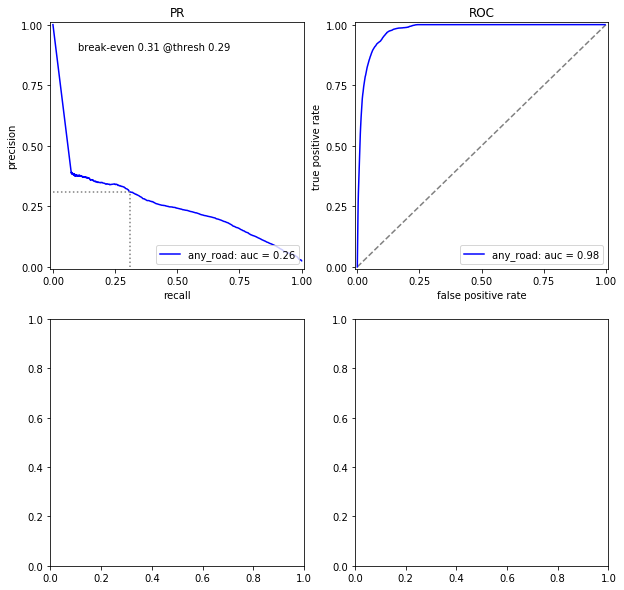

In [6]:
(fpr_dict, 
tpr_dict,
roc_auc_dict, 
precision_dict, 
recall_dict,
pr_auc_dict,
beven_ix_dict,
beven_thresh_dict,
reduced_class_dict) = multiclass_roc_pr(arr_y, arr_yscore, class_dict=class_dict)

# set up summary figure
fig_sum, axs = plt.subplots(2, 2, figsize=(10, 10))
plot_pr(recall_dict, precision_dict, pr_auc_dict, beven_ix_dict, beven_thresh_dict, axs[0, 0])
plot_roc(fpr_dict, tpr_dict, roc_auc_dict, axs[0, 1])
plt.show()

In [7]:
# prepare index for showing samples
if mode_sample_choice is None:
    samples_ix = [ix for ix, fn in enumerate(file_list_x[:num_x_use]) if fn in file_list_selected]
    if not len(samples_ix):
        raise Exception("none of the tiles selected for individual plotting is among the tiles analyzed")
else:
    samples_ix = utils.gen_sample_index(num_x_use, num_x_show, mode_sample_choice=mode_sample_choice, metric=arr_metric)

### Show individual samples

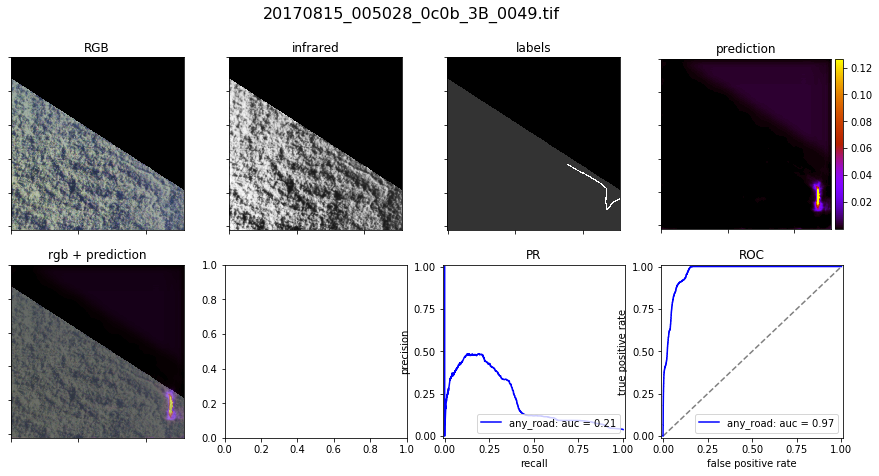

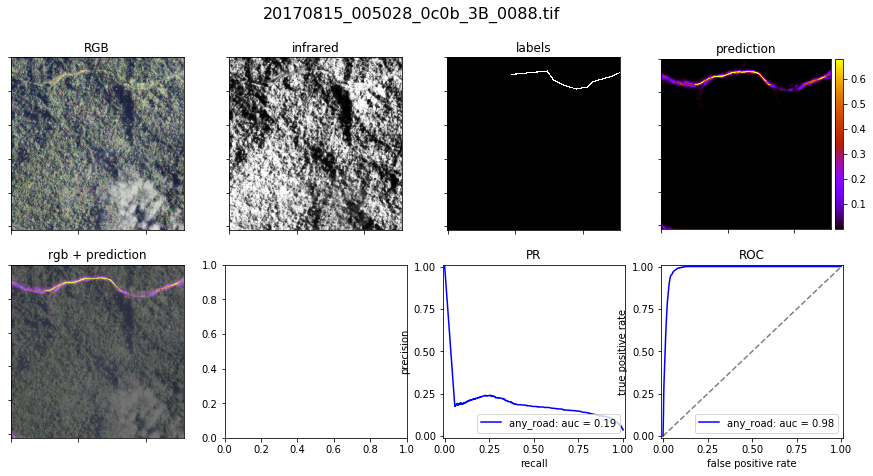

In [8]:
for ix in samples_ix:
    fn = file_list_x[ix]
    # read sat image tile
    x = io.imread(os.path.join(dir_eval, dir_x, fn))
    # retrieve labels
    y = arr_y[ix*img_size:(ix+1)*img_size].reshape(target_size + (1,), order = 'C')
    # retrieve y score (prediction)
    yscore = arr_yscore[ix*img_size:(ix+1)*img_size, :].reshape(target_size + (dim_yscore,), order = 'C')
    fig_sample = show_sample_prediction(x, y, yscore, class_dict, title=fn)

In [9]:
samples_ix

[0, 3]

In [10]:
# halt
sys.exit()

SystemExit: 

/home/hh/anaconda3/envs/geo/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Outdated stuff
which is not used currently but may come in handy later

In [ ]:
# a quick test of multiclass_roc
multiclass_roc(np.r_[0, 40, 40, 0, 255, 255, 0, 255], np.empty(8))

In [ ]:

# input arguments to Keras' ImageDataGenerator - be sure not to include any image augmentation here!
data_gen_args = dict(data_format="channels_last")

# batch size for summary stats without visualization (the more, the more efficient, but limited by memory)
batch_size = 3


# 'steps' input par into evaluate_generator
steps =  num_x_use // batch_size


### Run evaluation: only numeric values

In [ ]:
# set up test gen with a batch size as large as possible for efficiency reasons
test_gen = trainGenerator(batch_size, eval_dir, img_dir, label_dir,
                        data_gen_args, save_to_dir = None, image_color_mode="rgba", target_size=target_size)
res = model.evaluate_generator(test_gen, steps=steps, workers=1, use_multiprocessing=True, verbose=1)

In [ ]:
model.metrics_names
res

### Run prediction for display of images and more sophisticated evaluation

In [ ]:
pred = model.predict_generator(test_gen, steps=steps, workers=1, use_multiprocessing=True, verbose=1)

In [ ]:
plt.imshow(pred[5].reshape(target_size), cmap='gray');
plt.colorbar()

### Set up ImageDataGenerator

In [ ]:
# this generator is supposed to yield single images and matching labels, hence batch size = 1
#batch1_test_gen = trainGenerator(1, eval_dir, img_dir, label_dir,
#                        data_gen_args, save_to_dir = None, image_color_mode="rgba", target_size=target_size)
# preallocate linear arrays for collecting flattened predicition and label data